# Pass Flow Map

Creating a map to show the flow of passes.

In [1]:
import sys,os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d, circmean

import importing_sb as imsb
import draw_pitch as dp

plt.style.use('football')

In [2]:
data_dir = 'data/open-data/data/'
event_data = imsb.open_data(data_dir + 'events/15946.json')
df = imsb.get_pass(event_data)

Focusing on Barcelona's passes and flipping the y-coordinate for plotting.

In [4]:
df = df[df['team'] == 'Barcelona'].copy()
df['y'] = df['y'].apply(lambda y: 80-y)
df['end_y'] = df['end_y'].apply(lambda y: 80-y)

In [5]:
df.head()

,index,event_id,period,minute,second,type,pos_team,play_pattern,team,player,...,cutback,switch,shot_assist,goal_assist,xA,body_part,pass_type,outcome,technique,progressive
2,10,f1cc47d6-4b19-45a6-beb9-33d67fc83f4b,1,0,6,Pass,Barcelona,Regular Play,Barcelona,Sergio Busquets i Burgos,...,False,False,None,None,NaN,Head,Recovery,Complete,None,False
3,12,f774571f-4b65-43a0-9bfc-6384948d1b82,1,0,8,Pass,Barcelona,Regular Play,Barcelona,Ivan Rakitić,...,False,False,None,None,NaN,Head,Standard,Complete,None,False
4,16,46f0e871-3e72-4817-9a53-af27583ba6c1,1,0,10,Pass,Barcelona,Regular Play,Barcelona,Ousmane Dembélé,...,False,False,None,None,NaN,Right Foot,Standard,Complete,None,False
5,18,719bbdb1-8743-4c95-b5a5-b61a0c392741,1,0,11,Pass,Barcelona,Regular Play,Barcelona,Jordi Alba Ramos,...,False,False,None,None,NaN,Left Foot,Standard,Incomplete,None,True
7,26,df65f591-1131-4565-ad3c-7295ccdf3f26,1,0,30,Pass,Barcelona,Regular Play,Barcelona,Marc-André ter Stegen,...,False,False,None,None,NaN,Keeper Arm,Standard,Complete,None,False


There are two approaches to plotting the pass flow map - use StatsBomb's provided *angle* value for the passes or calculate the angle ourselves. The second approach is more general but firstly I will demonstrate the concept using the StatsBomb provided *angle* value.

In [203]:
vals, x_edge, y_edge, binnum = binned_statistic_2d(df['x'].values,df['y'].values, values=df['x'].values,
                                                   bins = (6,4), range = [[0,120],[0,80]],
                                                   statistic='count', expand_binnumbers=True)

In [204]:
vals

array([[ 6., 17., 10., 12.],
       [16., 18., 19., 16.],
       [26., 55., 42., 37.],
       [67., 67., 66., 79.],
       [69., 53., 68., 81.],
       [21., 14., 12., 19.]])

As we see, the *x* values are rows and *y* the columns so this needs to be transposed to be plotted on a horizontal pitch.

In [205]:
vals = vals.T

In [206]:
vals

array([[ 6., 16., 26., 67., 69., 21.],
       [17., 18., 55., 67., 53., 14.],
       [10., 19., 42., 66., 68., 12.],
       [12., 16., 37., 79., 81., 19.]])

Then find create the grid and the midpoints.

In [207]:
x_grid, y_grid = np.meshgrid(x_edge,y_edge)

In [208]:
x_mid, y_mid = np.meshgrid(x_edge[:-1] + np.diff(x_edge) / 2, y_edge[:-1] + np.diff(y_edge) / 2)

Now find the average angle in each bin. *scipy.stats* has the useful `circmean` function for finding the mean of angles. StatsBomb measure angle as 0 being the attacking direction then negative radians in the counter-clockwise direction and positive radians in the clockwise direction. However, when plotting using `quiver` it can take a list of *angle* values for each arrow and this angle is measured in degrees positvely in the counter-clockwise direction from the horizontal axis. Therefore, when plotting a horizontal pitch, the StatsBomb angles can easily be converted to those appropriate for `quiver` by multiplying by $-1$ and then converting to degrees.

In [209]:
stats, *_ = binned_statistic_2d(df['x'].values,df['y'].values, values=df['angle'].values*-1,
                                                   bins = (6,4), range = [[0,120],[0,80]],
                                                   statistic=circmean, expand_binnumbers=True)

Transpose and convert to degrees.

In [210]:
angles = np.degrees(stats.T)

In [211]:
angles

array([[ 65.94069029,  72.74331004,  86.2038787 ,  53.42989294,
        103.57175403, 139.07110266],
       [ 23.32067423,  63.4874024 ,  29.49511425,  24.93026552,
         34.8951155 ,  37.78124959],
       [ 15.36086629, 345.14935905,   7.40475689, 351.98023197,
        322.14366972, 293.22302459],
       [276.90672175, 278.87670784, 299.27633002, 299.40014149,
        250.24963094, 244.88939895]])

In the case where no passes are played from a zone, the length (controlled here by the *U* vector) is set to zero such that no arrow is seen.

In [212]:
locs = np.where(vals == 0)
locs_list = list(zip(locs[0], locs[1]))

In [213]:
U = np.full((x_mid.shape[0],x_mid.shape[1]), 0.042)
for i in locs_list:
    U[i] = 0

Finally, plot the pass flow map.

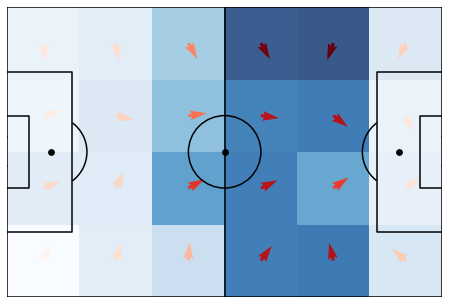

In [323]:
fig, ax = dp.draw_pitch('w','k','h','f',fig_width=8)

ax.quiver(x_mid,y_mid,U,0, 
          vals, angles=angles, scale=1, scale_units='width', cmap='Reds')
ax.imshow(vals, origin='lower', extent=(0,120,0,80), alpha=0.8, cmap='Blues')
ax.set_xlim(0,120)
ax.set_ylim(0,80)

plt.show()

## Create function for plotting pass flow maps

In [313]:
def calc_angle(xstart, ystart, xend, yend):
    xstart, ystart, xend, yend = np.array(xstart), np.array(ystart), np.array(xend), np.array(yend)
    xdist = xend - xstart
    ydist = yend - ystart
    angle = np.arctan2(ydist, xdist)
    return angle

In [324]:
def pass_flow(xstart, ystart, xend, yend, angles=None, bins=(6,4), length=None, arr_cmap='viridis', bin_cmap='Blues'):
    """
    Parameters
    ----------
    angles : array-like
        Must be the same size as the xstart and ystart arrays. Measured in degrees, 0 is pointing "eastwards" and 
        counting counter-clockwise. Accepts negative angle values which count clockwise. If using StatsBomb data, 
        simply multiply their angle value by -1 and change to degrees.
    """
    if angles is None:
        if xend is None or yend is None:
            raise ValueError("Provide array-like values for xend and yend.")
        
        counts, xedge, yedge, bin_num = binned_statistic_2d(xstart, ystart, values=xstart, bins = bins, 
                                                             range = [[0,120],[0,80]], statistic='count', 
                                                             expand_binnumbers=True)
        counts = counts.T # Make x correspond to columns for horizontal pitch plotting
        
        angles = calc_angle(xstart, ystart, xend, yend)
        angles_bin, *_ = binned_statistic_2d(xstart, ystart, values=angles, bins=bins, range=[[0,120],[0,80]], 
                                             statistic=circmean, expand_binnumbers=True)
        angles_bin = angles_bin.T
        
        # If length isn't specified default to half of the shortest side of the bin so arrow doesn't extend beyond bin
        if length is None:
            if np.diff(xedge)[0] <= np.diff(yedge)[0]:
                length = np.diff(xedge)[0] / 2
            else:
                length = np.diff(yedge)[0] / 2
        
        xdiff = np.cos(angles_bin) * length
        ydiff = np.sin(angles_bin) * length
        
        # Create the grid and the grid of bin centres
        x_grid, y_grid = np.meshgrid(xedge,yedge)
        x_mid, y_mid = np.meshgrid(xedge[:-1] + np.diff(xedge) / 2, yedge[:-1] + np.diff(yedge) / 2)
        
        angles_bin = np.degrees(angles_bin) # Change to degrees for quiver plotting
        ax.quiver(x_mid, y_mid, xdiff, ydiff, counts, angles='xy', scale=1, scale_units='xy', cmap=arr_cmap)
        ax.imshow(counts, origin='lower', extent=(0,120,0,80), alpha=0.8, cmap=bin_cmap)
    
    else:
        counts, xedge, yedge, bin_num = binned_statistic_2d(xstart, ystart, values=xstart, bins = bins, 
                                                             range = [[0,120],[0,80]], statistic='count', 
                                                             expand_binnumbers=True)
        counts = counts.T # Make x correspond to columns for horizontal pitch plotting

        angles_bin, *_ = binned_statistic_2d(xstart, ystart, values=angles, bins = bins, range = [[0,120],[0,80]], 
                                    statistic=circmean, expand_binnumbers=True)
        angles_bin = np.degrees(angles_bin.T)

        # Create the grid and the grid of bin centres
        x_grid, y_grid = np.meshgrid(xedge,yedge)
        x_mid, y_mid = np.meshgrid(xedge[:-1] + np.diff(xedge) / 2, yedge[:-1] + np.diff(yedge) / 2)

        # If length is not specified then set it to be half bin-width
        if length is None:
            length = 1 / (2*bins[0])

        # When providing the angles directly the length of the arrows is simply determined by the U vector
        U = np.full((x_mid.shape[0],x_mid.shape[1]), length)

        # Setting arrow length to zero in bins where there were no passes
        zero_locs = np.where(counts == 0)
        zeros_list = list(zip(zero_locs[0], zero_locs[1]))
        for i in zeros_list:
            U[i] = 0

        ax.quiver(x_mid, y_mid, U, 0, counts, angles=angles_bin, scale=1, scale_units='width', cmap=arr_cmap, zorder=10)
        ax.imshow(counts, origin='lower', extent=(0,120,0,80), alpha=0.8, cmap=bin_cmap)

    plt.show()
    
    return ax

Providing array of angle values (as one could do with the StatsBomb data):

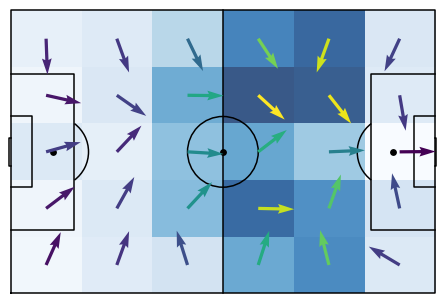

In [325]:
fig, ax = dp.draw_pitch('w','k','h','f',fig_width=8)
pass_flow(df['x'].values, df['y'].values, df['end_x'].values, df['end_y'].values, angles=df['angle'].values*-1, 
          bins=(6,5))

Just providing starting and ending coordinates and calculating the angles ourselves:

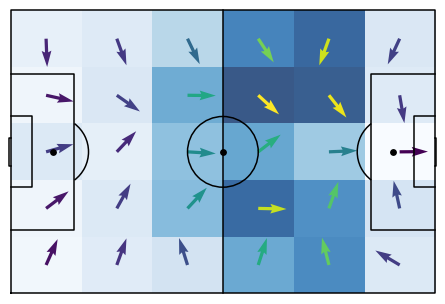

In [326]:
fig, ax = dp.draw_pitch('w','k','h','f',fig_width=8)
pass_flow(df['x'].values, df['y'].values, df['end_x'].values, df['end_y'].values, bins=(6,5))